# CEH Land Cover Data

The CEH landcover data can be downloaded from here:
https://www.ceh.ac.uk/data/ukceh-land-cover-maps


In [18]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from sdm.extract import ceh_lc_types
from sdm.geo import load_boundary
from sdm.geo import reproject_to_model_raster


In [20]:
land_cover = rxr.open_rasterio("data/raw/big-files/FME_333C3E30_1697306926587_135756/data/a22baa7c-5809-4a02-87e0-3cf87d4e223a/ukregion-yorkshireandthehu.tif")
land_cover

<xarray.DataArray (band: 2, y: 14066, x: 17912)>
[503900384 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 3.632e+05 3.632e+05 ... 5.423e+05 5.423e+05
  * y            (y) float64 5.192e+05 5.192e+05 ... 3.786e+05 3.786e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
land_cover_key = ceh_lc_types()

## Clip to Boundary

In [22]:
boundary = load_boundary()
boundary["geometry"] = boundary.geometry.buffer(10000)
boundary

,County,geometry
0,South Yorkshire,"POLYGON ((402394.049 396643.875, 402336.261 39..."


In [23]:
land_cover = land_cover.rio.clip_box(*boundary.total_bounds, crs=boundary.crs)
land_cover = land_cover.where(land_cover != land_cover.rio.nodata, np.nan)
land_cover.rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray (band: 2, y: 5120, x: 8522)>
array([[[11., 11., 11., ...,  3.,  3.,  3.],
        [11., 11., 11., ...,  3.,  3.,  3.],
        [11., 11., 11., ...,  3.,  3.,  3.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[73., 73., 80., ..., 95., 93., 95.],
        [72., 70., 79., ..., 95., 93., 94.],
        [64., 64., 63., ..., 95., 91., 89.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 4.009e+05 4.009e+05 ... 4.861e+05 4.861e+05
  * y            (y) float64 4.298e+05 4.297e+05 ... 3.786e+05 3.786e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

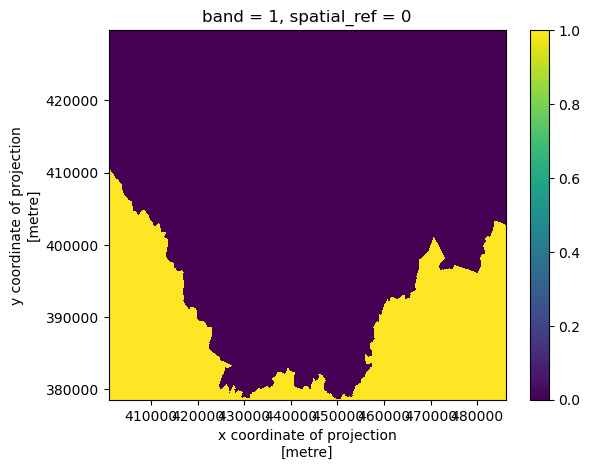

In [24]:
(np.isnan(land_cover[0])).plot()

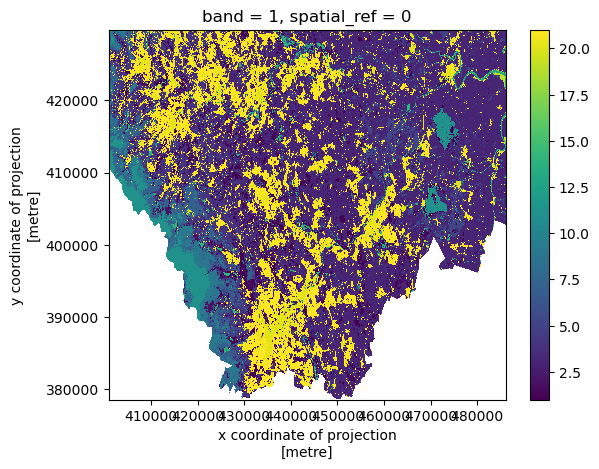

In [25]:
land_cover[0].plot()

## Convert the Array

In [26]:
def get_land_cover_category(array, key: int, label: str):
    # Generate an array of zeros the same shape as the input array
    cat_array = xr.zeros_like(array, dtype=np.float64)
    # Then set the output array to 1 where it matches the category int key
    cat_array = cat_array.where(array != key, 1)
    # Where the input array has missing values, set the output array to missing
    cat_array = cat_array.where(~np.isnan(array), np.nan)
    # Then convert it to a dataset with the habitat category as the name
    cat_array = cat_array.to_dataset(name=label)
    return cat_array


land_cover_categories = [
    get_land_cover_category(land_cover[0], int(key), label)
    for key, label in land_cover_key.items()
]

In [27]:
lc_stack = xr.merge(land_cover_categories)
lc_stack

<xarray.Dataset>
Dimensions:                 (x: 8522, y: 5120)
Coordinates:
    band                    int64 1
  * x                       (x) float64 4.009e+05 4.009e+05 ... 4.861e+05
  * y                       (y) float64 4.298e+05 4.297e+05 ... 3.786e+05
    spatial_ref             int64 0
Data variables: (12/21)
    Broadleaved woodland    (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Coniferous woodland     (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Arable                  (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Improved grassland      (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Neutral grassland       (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Calcareous grassland    (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ...                      ...
    Supralittoral sediment  (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Littoral rock           (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Littoral sediment       (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Saltmarsh               (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Urban                   (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Suburban                (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan

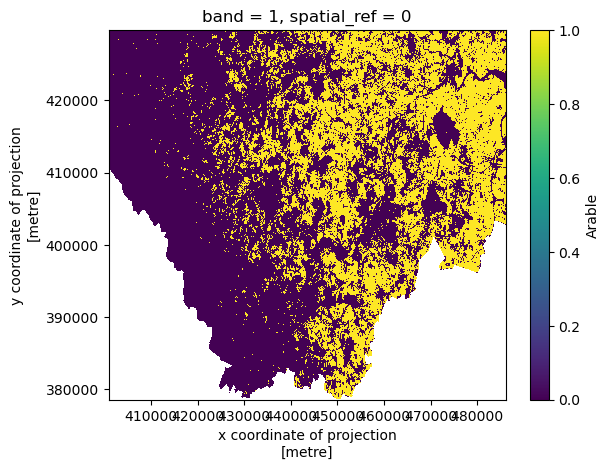

In [28]:
lc_stack["Arable"].plot()

# Coarsen the Array

The modelling will be at 100m so to convert this data into some numerical feature I'm summing the 10m pixels (0 - not category, 1 - is category) into the 100m pixels. 

In [29]:
# Convert them into area units
lc_stack = lc_stack * 100 # If a square is 10m resolution and it has a value of 1 then it is 100m^2
# Then sum them to get the total area of each habitat type in each 100m square
lc_100m = lc_stack.coarsen(x=10, y=10, boundary="trim").sum(skipna=False)
lc_100m

<xarray.Dataset>
Dimensions:                 (y: 512, x: 852)
Coordinates:
    band                    int64 1
  * x                       (x) float64 4.009e+05 4.01e+05 ... 4.86e+05
  * y                       (y) float64 4.297e+05 4.296e+05 ... 3.786e+05
    spatial_ref             int64 0
Data variables: (12/21)
    Broadleaved woodland    (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Coniferous woodland     (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Arable                  (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Improved grassland      (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Neutral grassland       (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Calcareous grassland    (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ...                      ...
    Supralittoral sediment  (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Littoral rock           (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Littoral sediment       (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Saltmarsh               (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Urban                   (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Suburban                (y, x) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [30]:
lc_100m = lc_100m.rio.clip(boundary.geometry, boundary.crs)
lc_100m = reproject_to_model_raster(lc_100m)

In [31]:
lc_100m.rio.to_raster("data/evs/ceh-land-cover-100m.tif")